## Introduction

This notebook is dedicated to the creation of loan interest rate prediction model. I will be using lightgbm regression model to predict the interest rate. 

## Importing necessary libraries

In [193]:
from lightgbm import LGBMRegressor

import functions as f
import pandas as pd

pd.set_option("display.max_columns", None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from functions import (
    CustomOrdinalEncoder,
    CustomWordExtractor,
    CustomCategoricalConverter,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import DropFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error
from skopt import BayesSearchCV

import shap

shap.initjs()

import pickle

## Importing Train and Test sets from EDA Notebook

In [194]:
train_set = pd.read_csv(
    "/Users/laurynas/Documents/DataScience/Projects/Data/lending-club/train_set_df_2.csv",
    low_memory=False,
)
test_set = pd.read_csv(
    "/Users/laurynas/Documents/DataScience/Projects/Data/lending-club/test_set_df_2.csv",
    low_memory=False,
)

In [195]:
X_train = train_set.drop(
    columns=["grade", "sub_grade", "int_rate", "issue_d", "earliest_cr_line"], axis=1
)
y_train = train_set["int_rate"]

## Building the Pipeline

In [196]:
emp_length_order = [
    "< 1 year",
    "1 year",
    "2 years",
    "3 years",
    "4 years",
    "5 years",
    "6 years",
    "7 years",
    "8 years",
    "9 years",
    "10+ years",
]
verification_status_order = [
    "Not Verified",
    "Verified",
    "Source Verified",
]
cat_features = [
    "home_ownership",
    "zip_code",
    "state",
    "initial_list_status",
    "application_type",
    "hardship_flag",
]
custom_word_pipeline = Pipeline(
    steps=[
        ("word_extractor", CustomWordExtractor(column_name=["emp_title", "purpose"])),
        (
            "ordinal_encoder",
            OrdinalEncoder(
                encoding_method="arbitrary", missing_values="ignore", unseen="encode"
            ),
        ),
    ]
)
preprocess_pipeline = ColumnTransformer(
    transformers=[
        (
            "employment_length_encoder",
            CustomOrdinalEncoder(
                column_name="employment_length", order=emp_length_order
            ),
            ["employment_length"],
        ),
        (
            "verification_status_encoder",
            CustomOrdinalEncoder(
                column_name="verification_status", order=verification_status_order
            ),
            ["verification_status"],
        ),
        ("custom_word_pipeline", custom_word_pipeline, ["emp_title", "purpose"]),
        (
            "cat_encoding",
            OrdinalEncoder(
                encoding_method="arbitrary", missing_values="ignore", unseen="encode"
            ),
            cat_features,
        ),
    ],
    remainder="passthrough",
)
preprocess_pipeline.set_output(transform="pandas")

ColumnTransformer(remainder='passthrough',
                  transformers=[('employment_length_encoder',
                                 CustomOrdinalEncoder(column_name='employment_length',
                                                      order=['< 1 year',
                                                             '1 year',
                                                             '2 years',
                                                             '3 years',
                                                             '4 years',
                                                             '5 years',
                                                             '6 years',
                                                             '7 years',
                                                             '8 years',
                                                             '9 years',
                                                             '10+ years']),
                                 ['employment_length']),
                                ('verification_status_encoder',
                                 CustomOrdinalEncoder(column_name='verification_st...
                                                  CustomWordExtractor(column_name=['emp_title',
                                                                                   'purpose'])),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(encoding_method='arbitrary',
                                                                 missing_values='ignore',
                                                                 unseen='encode'))]),
                                 ['emp_title', 'purpose']),
                                ('cat_encoding',
                                 OrdinalEncoder(encoding_method='arbitrary',
                                                missing_values='ignore',
                                                unseen='encode'),
                                 ['home_ownership', 'zip_code', 'state',
                                  'initial_list_status', 'application_type',
                                  'hardship_flag'])])

In [197]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=True, random_state=42
)

In [198]:
cat_features = [
    "employment_length_encoder__employment_length",
    "verification_status_encoder__verification_status",
    "custom_word_pipeline__emp_title",
    "custom_word_pipeline__purpose",
    "cat_encoding__home_ownership",
    "cat_encoding__zip_code",
    "cat_encoding__state",
    "cat_encoding__initial_list_status",
    "cat_encoding__application_type",
    "cat_encoding__hardship_flag",
]
pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess_pipeline),
        (
            "convert_to_categorical",
            CustomCategoricalConverter(columns_to_convert=cat_features),
        ),
    ]
)
X_train_transformed = pipeline.fit_transform(X_train)
X_valid_transformed = pipeline.transform(X_valid)

In [199]:
classifier = LGBMRegressor(random_state=1, n_jobs=-1)
classifier.fit(
    X_train_transformed,
    y_train,
    early_stopping_rounds=15,
    eval_set=[(X_valid_transformed, y_valid)],
    verbose=-1,
)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


LGBMRegressor(random_state=1)

In [200]:
y_pred = classifier.predict(X_train_transformed)
score = classifier.score(X_train_transformed, y_train)
print(f"Score: {score}")
rmse = mean_squared_error(y_train, y_pred, squared=False)
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_train, y_pred)
print(f"MAE: {mae}")

Score: 0.8595214280223421
RMSE: 1.8119879924274809
MAE: 1.3295640878585047


In [201]:
y_pred = classifier.predict(X_valid_transformed)
score = classifier.score(X_valid_transformed, y_valid)
print(f"Score: {score}")
rmse = mean_squared_error(y_valid, y_pred, squared=False)
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_valid, y_pred)
print(f"MAE: {mae}")

Score: 0.8589486013193908
RMSE: 1.814298331756988
MAE: 1.3312813992548937


<Axes: >

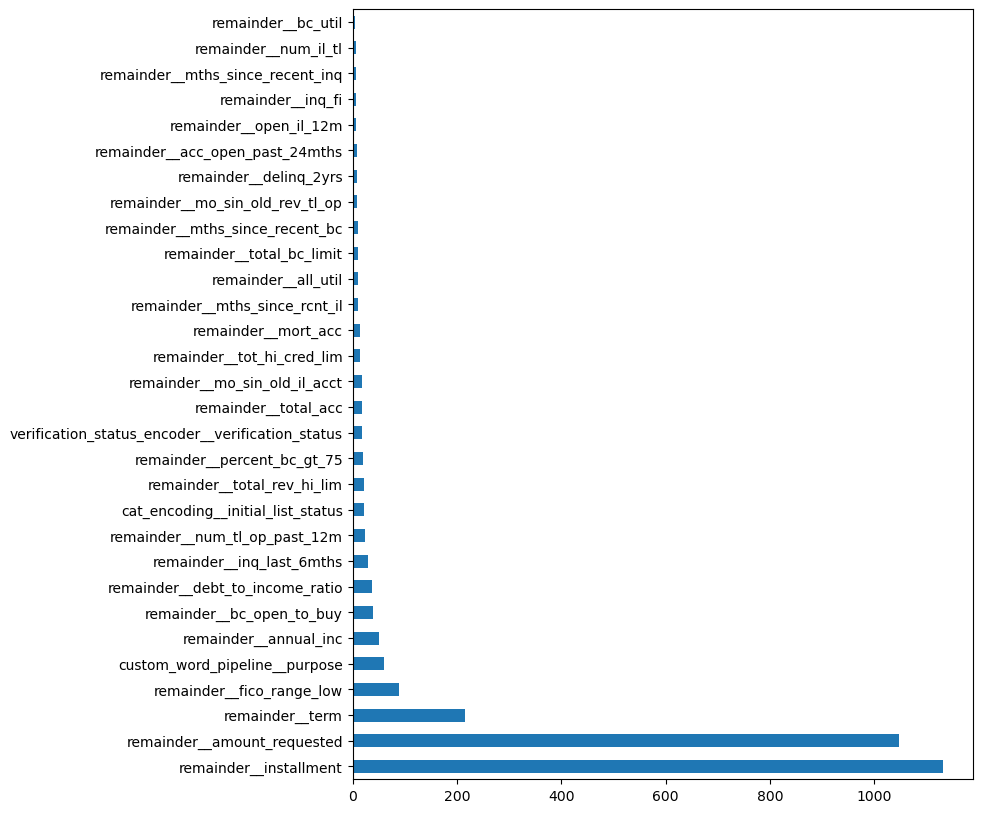

In [202]:
feat_imp = pd.Series(classifier.feature_importances_, index=X_train_transformed.columns)
feat_imp.nlargest(30).plot(kind="barh", figsize=(8, 10))

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


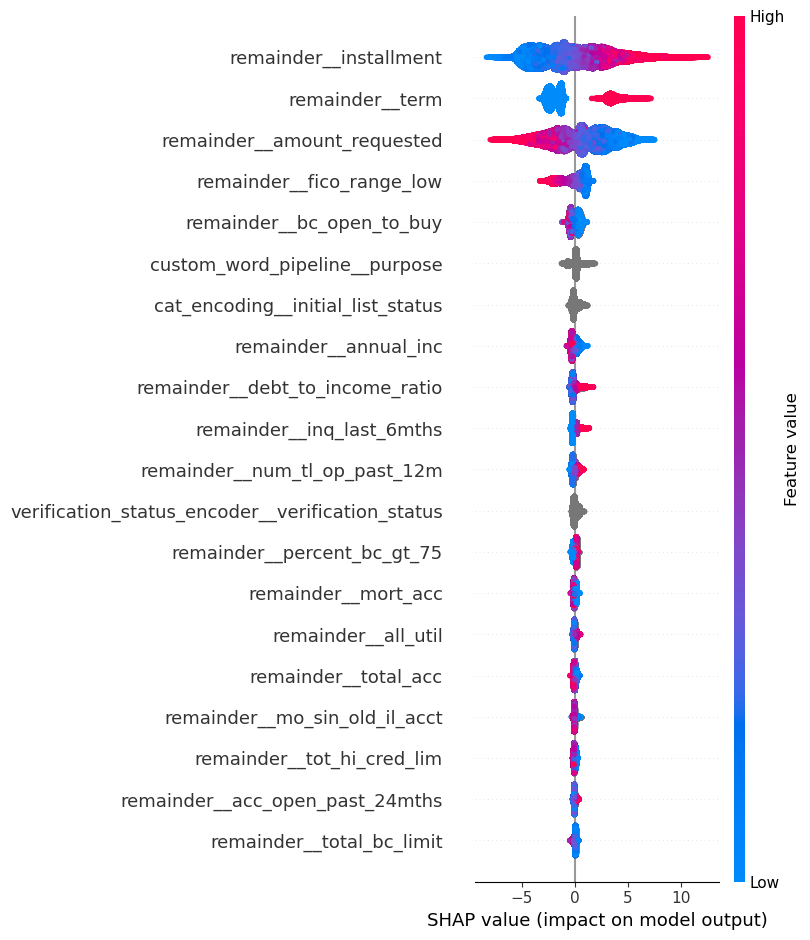

In [16]:
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X_train_transformed)
shap.summary_plot(shap_values, X_train_transformed)

In [204]:
selected_features = [
    "remainder__installment",
    "remainder__term",
    "remainder__amount_requested",
    "remainder__fico_range_low",
    "remainder__bc_open_to_buy",
    "custom_word_pipeline__purpose",
    "remainder__annual_inc",
    "remainder__debt_to_income_ratio",
]
features_to_drop = list(set(X_train_transformed.columns) - set(selected_features))
final_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess_pipeline),
        ("convert_to_categorical", CustomCategoricalConverter(cat_features)),
        ("drop_features", DropFeatures(features_to_drop)),
    ]
)
X_train_transformed = final_pipeline.fit_transform(X_train)
X_valid_transformed = final_pipeline.transform(X_valid)

In [ ]:
param_space = {
    'learning_rate': (0.01, 0.1, 'log-uniform'),
    'n_estimators': (50, 500),
    'num_leaves': (31, 250),
    'max_bin': (255, 500),
    'max_depth': (5, 15),
    'min_data_in_leaf': (20, 200),
    'early_stopping_rounds': (5, 20),
}
opt = BayesSearchCV(
    classifier,
    param_space,
    n_iter=20,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=3,
    verbose=1
)
opt.fit(X_train_transformed, y_train, eval_set = [(X_valid_transformed, y_valid)])

In [13]:
opt.best_params_

OrderedDict([('early_stopping_rounds', 5),
             ('learning_rate', 0.07066083608084753),
             ('max_bin', 500),
             ('max_depth', 15),
             ('min_data_in_leaf', 200),
             ('n_estimators', 468),
             ('num_leaves', 250)])

In [205]:
clf = LGBMRegressor(random_state=1, n_jobs=-1, **opt.best_params_)
clf.fit(X_train_transformed, y_train, eval_set=[(X_valid_transformed, y_valid)], verbose=-1)

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


LGBMRegressor(early_stopping_rounds=5, learning_rate=0.07066083608084753,
              max_bin=500, max_depth=15, min_data_in_leaf=200, n_estimators=468,
              num_leaves=250, random_state=1)

In [206]:
y_pred = clf.predict(X_train_transformed)
score = clf.score(X_train_transformed, y_train)
print(f"Score: {score}")
rmse = mean_squared_error(y_train, y_pred, squared=False)
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_train, y_pred)
print(f"MAE: {mae}")

Score: 0.9907685866965845
RMSE: 0.46449855915990057
MAE: 0.28139342348868407


In [207]:
y_pred = clf.predict(X_valid_transformed)
score = clf.score(X_valid_transformed, y_valid)
print(f"Score: {score}")
rmse = mean_squared_error(y_valid, y_pred, squared=False)
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_valid, y_pred)
print(f"MAE: {mae}")

Score: 0.989266343250304
RMSE: 0.500488213371728
MAE: 0.29459446142253043


Text(0, 0.5, 'Residuals')

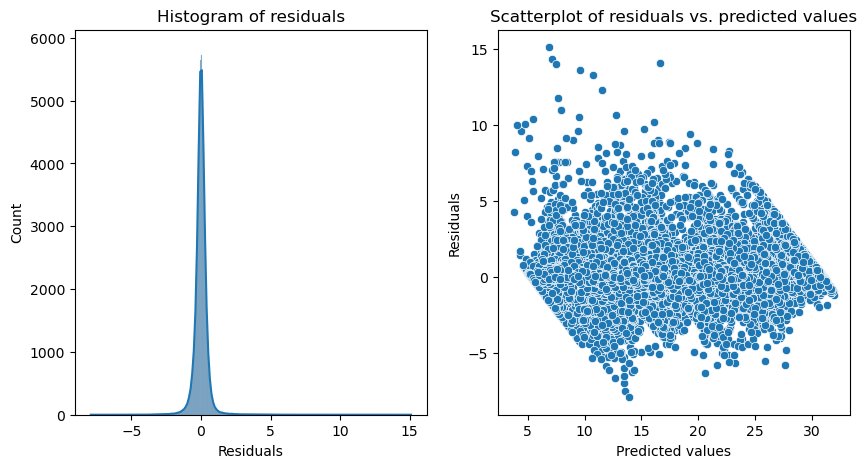

In [208]:
residuals = y_valid - y_pred

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(residuals, kde=True, ax=axs[0])
axs[0].set_title("Histogram of residuals")
axs[0].set_xlabel("Residuals")
sns.scatterplot(x=y_pred, y=residuals, ax=axs[1])
axs[1].set_title("Scatterplot of residuals vs. predicted values")
axs[1].set_xlabel("Predicted values")
axs[1].set_ylabel("Residuals")

## Final Model Evaluation on the Test Set

In [209]:
X_test = test_set.drop(
    columns=["grade", "sub_grade", "int_rate", "issue_d", "earliest_cr_line"], axis=1
)
y_test = test_set["int_rate"]
X_test_transformed = final_pipeline.transform(X_test)

In [210]:
y_pred = clf.predict(X_test_transformed)
score = clf.score(X_test_transformed, y_test)
print(f"Score: {score}")
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse}")
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

Score: 0.9891561101313451
RMSE: 0.5025177687554199
MAE: 0.29445238615553665


Text(0, 0.5, 'Residuals')

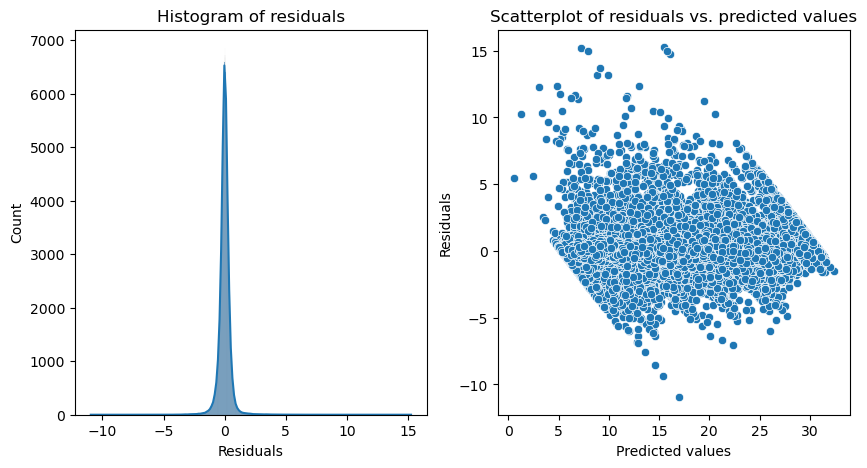

In [211]:
residuals = y_test - y_pred

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(residuals, kde=True, ax=axs[0])
axs[0].set_title("Histogram of residuals")
axs[0].set_xlabel("Residuals")
sns.scatterplot(x=y_pred, y=residuals, ax=axs[1])
axs[1].set_title("Scatterplot of residuals vs. predicted values")
axs[1].set_xlabel("Predicted values")
axs[1].set_ylabel("Residuals")

## Saving the Final Model

In [212]:
# with open("interest_rate_model-0.1.0.pkl", "wb") as f:
#     pickle.dump(clf, f)